In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import ADS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Stability or Robustness
- We consider the stability of ADS (regression models) given the uncertainty of the input data. 
    - Specifically, the uncertainty of the input data is captured by small fluctuations in the training set. Considering that regression, especially random forest model has high variance, i.e., tend to overfit. 
    - Small fluctuations are done by tuning the value of numerical attributes by a small amount for some instances in the training set.
    - We analyze the impact considering the number of attributes being tuned and the size of tuned instances.
- We want to quantify the stability or robusteness of our ADS. 
    - Stability or robustness of the ADS is measured as the variance of ADS's accuracy (mean squared error) regarding to the small fluctuations in the training set.

In [2]:
def run_perturnation(_data, _pertub_atts, model_name="random", instance_size=0.01, perturb_level=10, p_times=10, split_times=10):
    res_df = pd.DataFrame(columns=["split_seed", "p_times", "acc_variance"])
    for ri in range(split_times):
        data_train, data_test = train_test_split(_data, test_size=0.33, random_state=ri)
        _, mean_acc = call_regression_model(model_name, data_train, data_test)
        perturbed_acc = []
        for pi in range(p_times):
            update_train = perturb_att_value(data_train, _pertub_atts, perturb_level=perturb_level, instance_size=instance_size)
            _, cur_acc = call_regression_model(model_name, update_train, data_test)
            perturbed_acc.append(cur_acc)
        
        ri_variance = sum((xi - mean_acc) ** 2 for xi in perturbed_acc) / len(perturbed_acc)
        res_df.loc[res_df.shape[0]] = [ri, p_times, ri_variance]
    return res_df

def perturb_att_value(_data, _perturb_atts, perturb_level=1, instance_size=0.01):
    if int(instance_size*_data.shape[0]) > 0:
        tuned_instance_idx = random.sample(list(_data.index), int(instance_size*_data.shape[0]))
    else:
        tuned_instance_idx = random.sample(list(_data.index), 1)
    for ti in tuned_instance_idx:
        for ai in _perturb_atts:
            cur_center = _data.loc[ti, ai]
            _data.loc[ti, ai] = np.random.uniform(max(0,cur_center-perturb_level),cur_center+perturb_level,1)
    return _data
def call_regression_model(_model_name, _train_data, _test_data):
    if _model_name == "linear":
        r_model = ADS.simpleLR(_train_data)
        X_test, y_test = ADS.prepareLR(_test_data)
        r_msr = r_model.score(X_test, y_test)
    elif _model_name == "polynomial":
        r_model = ADS.polynomialLR(_train_data)
        X_test, y_test = ADS.preparePoly(_test_data)
        r_msr = r_model.score(X_test, y_test)
    else: # random forest
        r_model = ADS.forest(_train_data)
        X_test, y_test = ADS.prepareForest(_test_data)
        y_pred = r_model.predict(X_test)
        r_msr = r2_score(y_test, y_pred)
    return r_model, r_msr

# The number of perturbed attributes

In [3]:
all_p_atts = [["age"], ["age", "bmi"]]
att_pert = pd.DataFrame(columns=["tuned_att_n", "split_seed", "p_times", "acc_variance"])
for pai in all_p_atts:
    data = pd.read_csv("insurance.csv")
    data = ADS.encode(data)
    cur_pert = run_perturnation(data, pai, model_name="random")
    cur_pert["tuned_att_n"] = len(pai)
    cur_pert = cur_pert.loc[:, att_pert.columns]
    att_pert = pd.concat([att_pert, cur_pert])
att_pert.head(5)

,tuned_att_n,split_seed,p_times,acc_variance
0,1,0.0,10.0,0.000005
1,1,1.0,10.0,0.000004
2,1,2.0,10.0,0.000016
3,1,3.0,10.0,0.000006
4,1,4.0,10.0,0.000008


# Visualization of number of replaced attributes 

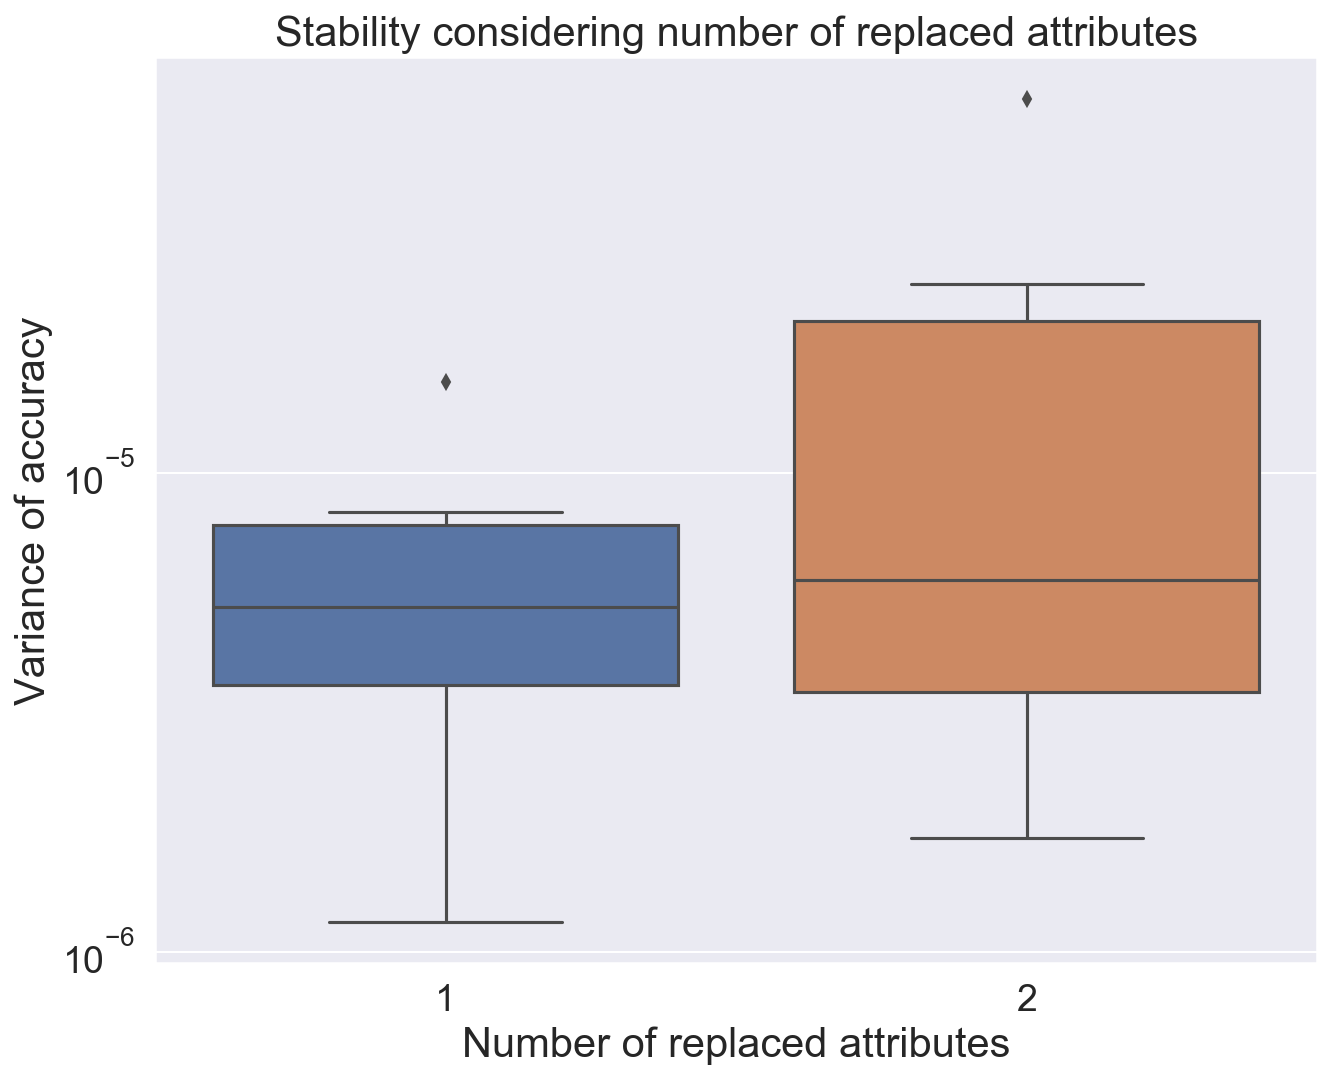

In [13]:
plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="tuned_att_n", y="acc_variance", data=att_pert)
plt.xlabel("Number of replaced attributes", fontsize=20)
plt.ylabel("Variance of accuracy", fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Stability considering number of replaced attributes", fontsize=20)
plt.savefig("Stability_att_n.png")

# The size of replaced instances

In [4]:
tune_size_list = [0.001, 0.01, 0.1, 0.2, 0.5]
tune_n_pert = pd.DataFrame(columns=["tuned_ratio", "split_seed", "p_times", "acc_variance"])
for tni in tune_size_list:
    data = pd.read_csv("insurance.csv")
    data = ADS.encode(data)
    cur_pert = run_perturnation(data, ["age"], model_name="random", instance_size=tni)
    cur_pert["tuned_ratio"] = tni
    cur_pert = cur_pert.loc[:, tune_n_pert.columns]
    tune_n_pert = pd.concat([tune_n_pert, cur_pert])
tune_n_pert.head(5)

,tuned_ratio,split_seed,p_times,acc_variance
0,0.001,0.0,10.0,2.369903e-07
1,0.001,1.0,10.0,9.135453e-07
2,0.001,2.0,10.0,2.493446e-07
3,0.001,3.0,10.0,1.005344e-06
4,0.001,4.0,10.0,3.016162e-07


In [8]:
tune_n_pert = pd.read_csv("Tune_n_pert.csv")
tune_n_pert.head(5)

,tuned_ratio,split_seed,p_times,acc_variance
0,0.001,0.0,10.0,2.369903e-07
1,0.001,1.0,10.0,9.135453e-07
2,0.001,2.0,10.0,2.493446e-07
3,0.001,3.0,10.0,1.005344e-06
4,0.001,4.0,10.0,3.016162e-07


# Visualization of size of replaced instances

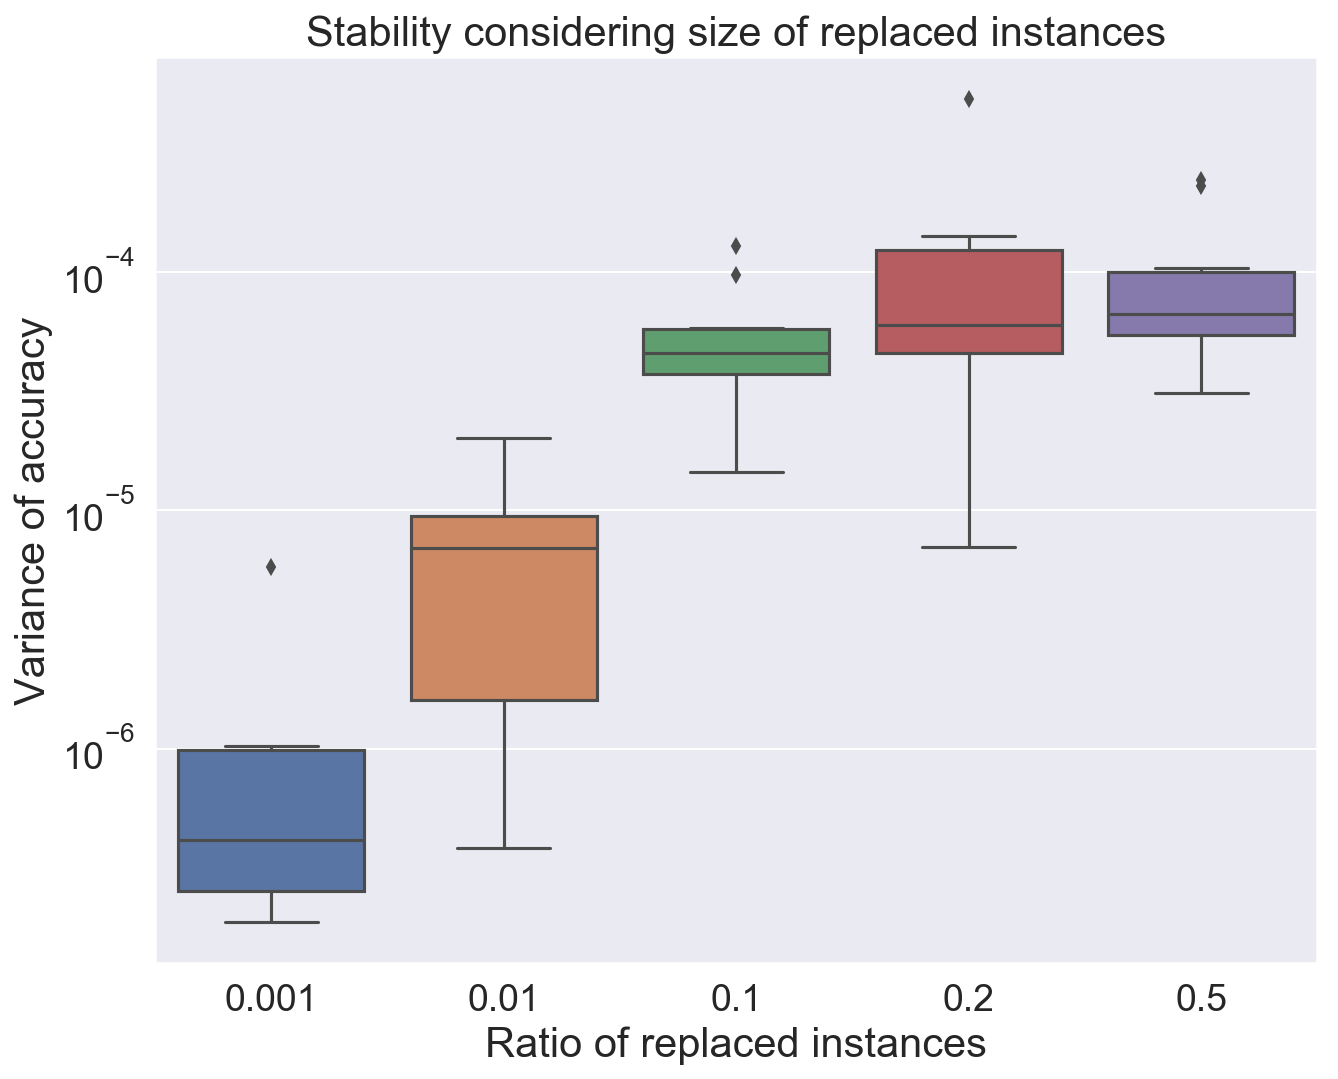

In [12]:
plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="tuned_ratio", y="acc_variance", data=tune_n_pert)
plt.xlabel("Ratio of replaced instances", fontsize=20)
plt.ylabel("Variance of accuracy", fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Stability considering size of replaced instances", fontsize=20)
plt.savefig("Stability_tune_n.png")

# The level of perturbation

In [5]:
tuned_atts = ["age"]
pt_level_list = [1, 5, 10, 20, 40] # for age
# pt_level_list = [1, 5, 10, 20, 40] # for bmi
pt_pert = pd.DataFrame(columns=["pt_radius", "split_seed", "p_times", "acc_variance"])
for pti in pt_level_list:
    data = pd.read_csv("insurance.csv")
    data = ADS.encode(data)
    cur_pert = run_perturnation(data, tuned_atts, model_name="random", instance_size=0.01, perturb_level=pti)
    cur_pert["pt_radius"] = pti
    cur_pert = cur_pert.loc[:, pt_pert.columns]
    pt_pert = pd.concat([pt_pert, cur_pert])
pt_pert.head(5)

,pt_radius,split_seed,p_times,acc_variance
0,1,0.0,10.0,3.240833e-07
1,1,1.0,10.0,3.379278e-06
2,1,2.0,10.0,1.170875e-05
3,1,3.0,10.0,4.686512e-07
4,1,4.0,10.0,2.302055e-06


# Visualization of perturbation level

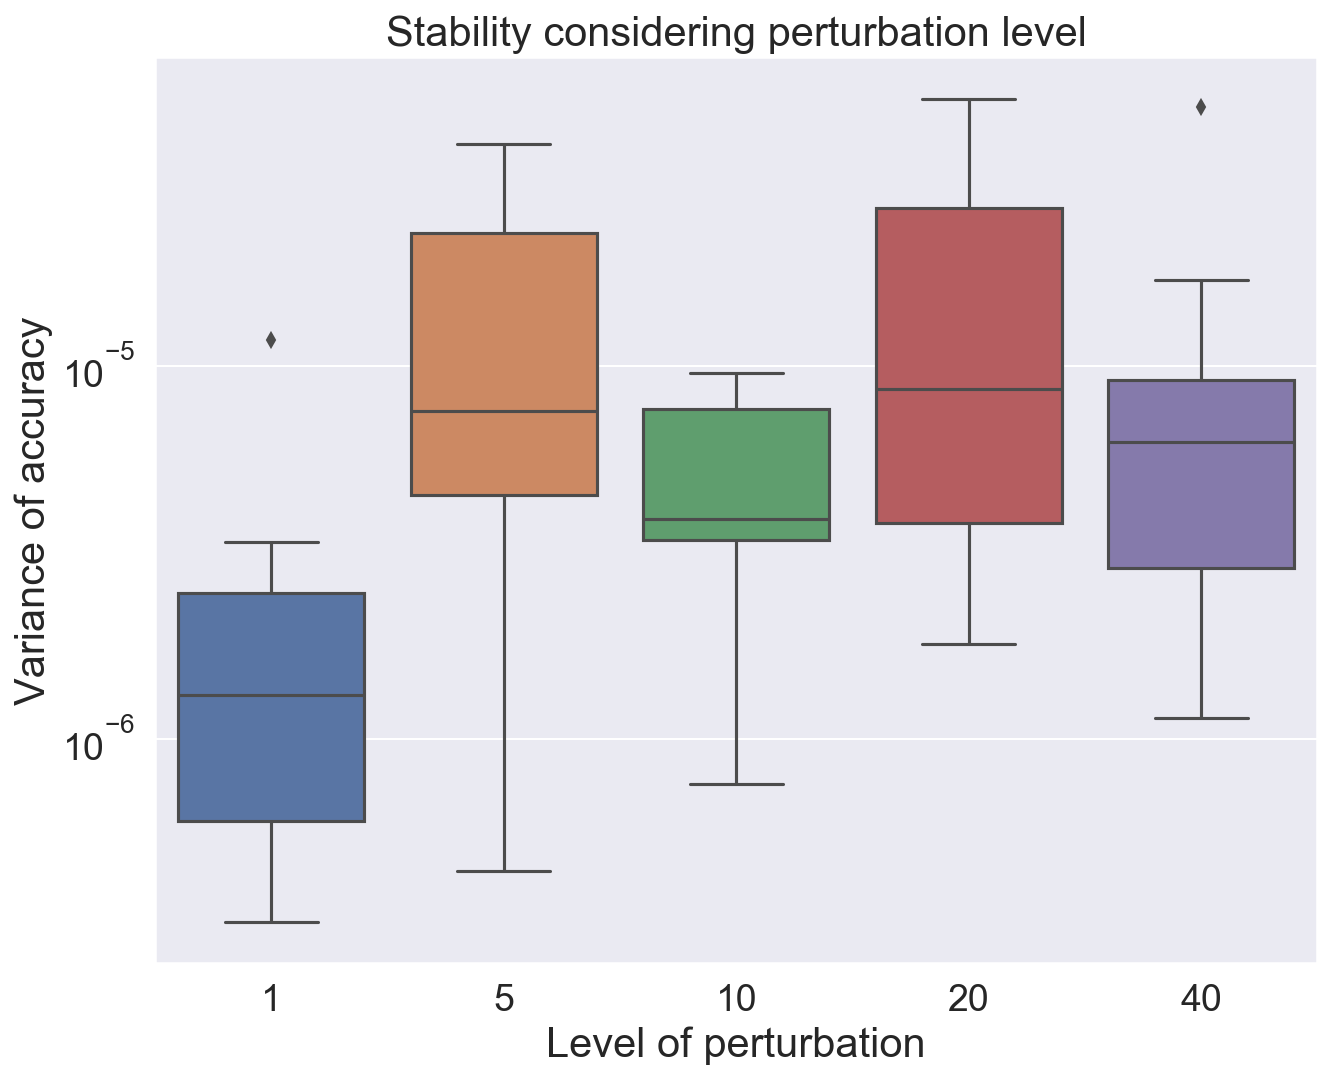

In [11]:
plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="pt_radius", y="acc_variance", data=pt_pert)
plt.xlabel("Level of perturbation", fontsize=20)
plt.ylabel("Variance of accuracy", fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Stability considering perturbation level", fontsize=20)
plt.savefig("Stability_pt.png")